# Setup

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from libHanSolo import unpacker
from matplotlib import pyplot

In [2]:
# Constants
INDEX_ORDER = [(x, x + 1024, x + 2048) for x in range(0, 1024)]
INPUT_SHAPE = (32, 32, 3)

In [3]:
def DataToImage(pixel_values):
    ordered = pixel_values[INDEX_ORDER]
    return np.array(ordered.reshape(INPUT_SHAPE))

def BatchToImages(batch):
    images = unpacker.get_value(batch, 'data')
    return np.array([DataToImage(image) for image in images])

def LabelToVector(label_value):
    arr = np.zeros(10)
    arr[label_value] = 1.0
    return arr

def BatchToLabelVector(batch):
    labels = unpacker.get_value(batch, 'labels')
    return np.array([LabelToVector(label) for label in labels])

def SetupData():
    batches = [unpacker.unpickle(f'./data/data_batch_{index}') for index in range(1, 6)]
    test = unpacker.unpickle(f'./data/test_batch')
    X_train = np.concatenate([BatchToImages(batch) for batch in batches])
    X_test = BatchToImages(test)
    y_train = np.concatenate([BatchToLabelVector(batch) for batch in batches])
    y_test = BatchToLabelVector(test)
    return [X_train, y_train, X_test, y_test]



In [4]:
[X_train, y_train, X_test, y_test] = SetupData()
print(f'{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}')

(50000, 32, 32, 3) (10000, 32, 32, 3) (50000, 10) (10000, 10)


<Figure size 720x720 with 0 Axes>

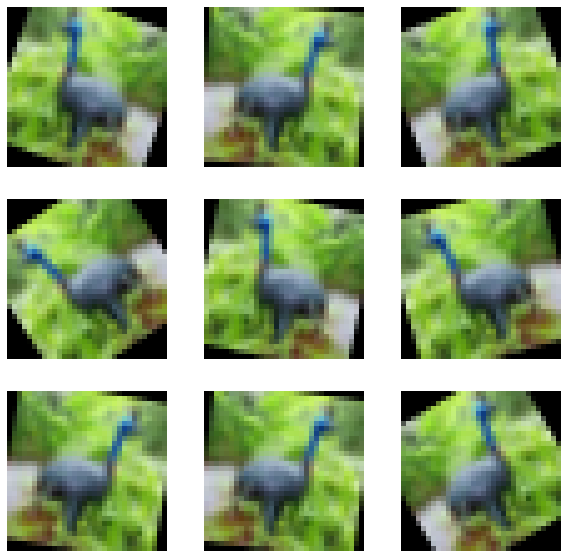

In [157]:
from matplotlib import pyplot

image = tf.expand_dims(X_train[6], 0)
pyplot.figure(figsize=(10, 10))

data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

pyplot.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image, training=True)
  ax = pyplot.subplot(3, 3, i + 1)
  pyplot.imshow(augmented_image[0])
  pyplot.axis("off")

# Resnet50 - transfer learning

In [42]:
model = keras.Sequential([
    keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE, pooling='avg'),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

def process(set):
    return keras.applications.resnet.preprocess_input(set)
    
X_train_processed = process(X_train)
X_test_processed = process(X_test)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 23,858,890
Trainable params: 23,805,770
Non-trainable params: 53,120
____________________________________

In [6]:
history_model = model.fit(X_train_processed, y_train, epochs=20, validation_data=(X_test_processed, y_test), batch_size=64)

Epoch 1/20
781/782 [============================>.] - ETA: 0s - loss: 1.4232 - accuracy: 0.5431

KeyboardInterrupt: 

# With preprocessing

In [ ]:
model_with_preprocessing = keras.Sequential([
    keras.Input(INPUT_SHAPE),
    keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE, pooling='avg'),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

model_with_preprocessing.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_with_preprocessing.summary()

def process(set):
    return keras.applications.resnet.preprocess_input(set)
    
X_train_processed = process(X_train)
X_test_processed = process(X_test)

In [ ]:
history_model_preprocessing = model_with_preprocessing.fit(X_train_processed, y_train, epochs=20, validation_data=(X_test_processed, y_test))

In [ ]:
model_no_weight = keras.Sequential([
    keras.applications.resnet50.ResNet50(include_top=False, input_shape=INPUT_SHAPE, pooling='avg'),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation="softmax")
])

model_no_weight.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_no_weight.summary()

def process(set):
    return keras.applications.resnet.preprocess_input(set)
    
X_train_processed = process(X_train)
X_test_processed = process(X_test)

In [ ]:
history_model_no_weight = model_no_weight.fit(X_train_processed, y_train, epochs=20, validation_data=(X_test_processed, y_test))

In [ ]:
model.save('data/models/resnet2')
model_with_preprocessing.save('data/models/preprocessed2')
model_no_weight.save('data/models/no-weights')

In [ ]:
loaded = keras.models.load_model('data/models/resnet2')
loaded.summary()